In [2]:
import numpy as np

%matplotlib widget
import matplotlib.pyplot as plt
#%matplotlib inline


from sqlalchemy import create_engine
from sqlalchemy.orm import Session
from sqlalchemy import select, func
from sqlalchemy import or_, and_

from db_scripts.brewbrain_db import BREWBRAIN_DB_ENGINE_STR, Base, CoreStyle, Style, Hop, Grain, Adjunct, Misc, Microorganism, RecipeML, RecipeMLGrainAT, RecipeMLHopAT, RecipeMLAdjunctAT, RecipeMLMiscAT

In [3]:
engine = create_engine(BREWBRAIN_DB_ENGINE_STR, echo=False, future=True)
Base.metadata.create_all(engine)

'''
fig = plt.figure(figsize=(20,500))

with Session(engine) as session:
  # Grab each available style
  styles = session.scalars(select(Style).group_by(Style.id)).all()

  mashph_means = np.zeros((len(styles)), dtype=np.float32)
  mashph_vars  = np.zeros_like(mashph_means)

  num_plots = len(styles)
  side_x_num = 6
  side_y_num = num_plots // side_x_num
  plot_x = 0
  plot_y = 0

  for i, style in enumerate(styles):
    # For each style we want to see the data distributions... 
    # mean, variation etc. for key attributes of the recipe
    recipes = session.scalars(select(RecipeML).filter_by(style=style)).all()
    
    mashphs       = np.zeros((len(recipes)), dtype=np.float32)
    mash_temps    = np.zeros_like(mashphs)
    ferment_temps = np.zeros_like(mashphs)

    for j, recipe in enumerate(recipes):
      mashphs[j] = float(recipe.mash_ph)

      for k in range(1,recipe.num_mash_steps+1):
        stepstr_prefix = "mash_step_"+str(k)
        #if getattr(recipe, stepstr_prefix+"_type") == "infusion":
        mash_temps[j] = max(mash_temps[j], float(getattr(recipe, stepstr_prefix + "_start_temp")))

      for k in range(1, recipe.num_ferment_stages+1):
        stepstr_prefix = "ferment_stage_"+str(k)
        ferment_temps[j] = max(ferment_temps[j], float(getattr(recipe, stepstr_prefix + "_temp")))

    if len(recipes) != 0:
      ax = fig.add_subplot(side_y_num, side_x_num, plot_x + 1 + plot_y*side_x_num)
      ax.set_title(style.name)
      ax.hist(ferment_temps, bins=50)
      #print(f"[{style.name}]: <Mash pH - Mean: {mashphs.mean()}, Var: {mashphs.var()}>")

    plot_x += 1
    if plot_x >= side_x_num:
      plot_x = 0
      plot_y += 1

  #session.scalars(select(RecipeML).filter_by(hash=recipe_ml.hash)).first()

fig.suptitle("Fermentation Temperatures (C)", y=1.0)
fig.tight_layout(pad=1.0)
plt.show()
'''

'\nfig = plt.figure(figsize=(20,500))\n\nwith Session(engine) as session:\n  # Grab each available style\n  styles = session.scalars(select(Style).group_by(Style.id)).all()\n\n  mashph_means = np.zeros((len(styles)), dtype=np.float32)\n  mashph_vars  = np.zeros_like(mashph_means)\n\n  num_plots = len(styles)\n  side_x_num = 6\n  side_y_num = num_plots // side_x_num\n  plot_x = 0\n  plot_y = 0\n\n  for i, style in enumerate(styles):\n    # For each style we want to see the data distributions... \n    # mean, variation etc. for key attributes of the recipe\n    recipes = session.scalars(select(RecipeML).filter_by(style=style)).all()\n    \n    mashphs       = np.zeros((len(recipes)), dtype=np.float32)\n    mash_temps    = np.zeros_like(mashphs)\n    ferment_temps = np.zeros_like(mashphs)\n\n    for j, recipe in enumerate(recipes):\n      mashphs[j] = float(recipe.mash_ph)\n\n      for k in range(1,recipe.num_mash_steps+1):\n        stepstr_prefix = "mash_step_"+str(k)\n        #if getatt

In [34]:
def query_values(column_names):
  values = []
  for column_name in column_names:
    values +=  session.query(column_name).all()
  values = np.array(values, dtype=np.float32).squeeze(1)
  return values[values != np.array(None)]

# Determine the distributions of all major values in recipes
with Session(engine) as session:
  mash_step_times = query_values([
    RecipeML.mash_step_1_time, RecipeML.mash_step_2_time, RecipeML.mash_step_3_time, 
    RecipeML.mash_step_4_time, RecipeML.mash_step_5_time, RecipeML.mash_step_6_time
  ])
  mash_step_temps = query_values([
    RecipeML.mash_step_1_start_temp, RecipeML.mash_step_2_start_temp, RecipeML.mash_step_3_start_temp, 
    RecipeML.mash_step_4_start_temp, RecipeML.mash_step_5_start_temp, RecipeML.mash_step_6_start_temp,
    RecipeML.mash_step_1_end_temp, RecipeML.mash_step_2_end_temp, RecipeML.mash_step_3_end_temp, 
    RecipeML.mash_step_4_end_temp, RecipeML.mash_step_5_end_temp, RecipeML.mash_step_6_end_temp,
  ])
  
  print(f"[Mash step times]: min: {np.min(mash_step_times)}, max: {np.max(mash_step_times)}, mean: {np.mean(mash_step_times)}, var: {np.var(mash_step_times)}")
  print(f"[Mash step temps]: min: {np.min(mash_step_temps)}, max: {np.max(mash_step_temps)}, mean: {np.mean(mash_step_temps)}, var: {np.var(mash_step_temps)}")



[Mash step times]: min: 0, max: 180, mean: 44.7646846816359, var: 695.8103352581271
[Mash step temps]: min: 0.0, max: 78.0, mean: 67.65409689364856, var: 52.65084059402701


In [37]:
# Determine the maximum numbers of ingredient types across all recipes, find outliers
with Session(engine) as session:

  grain_count_q   = session.query(RecipeML.id, func.count(RecipeMLGrainAT.id)).outerjoin(RecipeMLGrainAT).group_by(RecipeML.id).all()
  hop_count_q     = session.query(RecipeML.id, func.count(RecipeMLHopAT.id)).outerjoin(RecipeMLHopAT).group_by(RecipeML.id).all()
  adjunct_count_q = session.query(RecipeML.id, func.count(RecipeMLAdjunctAT.id)).outerjoin(RecipeMLAdjunctAT).group_by(RecipeML.id).all()
  misc_count_q    = session.query(RecipeML.id, func.count(RecipeMLMiscAT.id)).outerjoin(RecipeMLMiscAT).group_by(RecipeML.id).all()

  #grain_count_q.sort(key=lambda x: x[1], reverse=True)
  #hop_count_q.sort(key=lambda x: x[1], reverse=True)
  #adjunct_count_q.sort(key=lambda x: x[1], reverse=True)
  #print(adjunct_count_q)
  
  grain_counts   = [n[1] for n in grain_count_q]
  hop_counts     = [n[1] for n in hop_count_q]
  adjunct_counts = [n[1] for n in adjunct_count_q]
  misc_counts    = [n[1] for n in misc_count_q]

  print(f"Max grains in a recipe:   {max(grain_counts)}")
  print(f"Max hops in a recipe:     {max(hop_counts)}")
  print(f"Max adjuncts in a recipe: {max(adjunct_counts)}")
  print(f"Max misc. in a recipe:    {max(misc_counts)}")
  print("----------------------------------------")

  # Max fermentation and mash stages
  mash_steps     = session.query(RecipeML.id, RecipeML.num_mash_steps).all()
  ferment_stages = session.query(RecipeML.id, RecipeML.num_ferment_stages).all()
  
  mash_steps.sort(key=lambda x: x[1], reverse=True)
  ferment_stages.sort(key=lambda x: x[1], reverse=True)

  #print(mash_steps)
  print(f"Max mash steps:     {mash_steps[0][1]}")
  print(f"Max ferment stages: {ferment_stages[0][1]}")

  # How many unique types are there for each ingredient?
  num_grains = session.query(Grain).count()
  print(f"Number of unique grains:   {num_grains}")
  num_hops = session.query(Hop).count()
  print(f"Number of unique hops:     {num_hops}")
  num_adjuncts = session.query(Adjunct).count()
  print(f"Number of unique adjuncts: {num_adjuncts}")
  num_miscs = session.query(Misc).count()
  print(f"Number of unique miscs:    {num_miscs}")
  print("----------------------------------------")

  act_num_grains_used = session.query(RecipeMLGrainAT.grain_id).group_by(RecipeMLGrainAT.grain_id).count()
  print(f"Actual number of grains used: {act_num_grains_used}")
  act_num_hops_used = session.query(RecipeMLHopAT.hop_id).group_by(RecipeMLHopAT.hop_id).count()
  print(f"Actual number of hops used:   {act_num_hops_used}")
  print("----------------------------------------")

  # What stages exist for various ingredients?
  hop_stages = session.query(RecipeMLHopAT.stage).group_by(RecipeMLHopAT.stage).all()
  print(f"Hop stages: {hop_stages}")
  misc_stages = session.query(RecipeMLMiscAT.stage).group_by(RecipeMLMiscAT.stage).all()
  print(f"Misc. stages: {misc_stages}")

Max grains in a recipe:   15
Max hops in a recipe:     32
Max adjuncts in a recipe: 8
Max misc. in a recipe:    19
----------------------------------------
Max mash steps:     6
Max ferment stages: 2
Number of unique grains:   1113
Number of unique hops:     355
Number of unique adjuncts: 363
Number of unique miscs:    155
----------------------------------------
Actual number of grains used: 732
Actual number of hops used:   272
Hop stages: [('aroma',), ('boil',), ('dry hop',), ('first wort',), ('mash',)]
Misc. stages: [('boil',), ('bottling',), ('mash',), ('primary',), ('secondary',)]


In [13]:

with Session(engine) as session:
  ids_to_remove = [29601, 31184, 5495, 37490, 25756, 29249, 25438, 438, 135, 2541, 23239, 23170, 35465, 11824, 35691, 3352, 858, 24610, 23795, 24117, 34303, 29821, 9899, 24172, 24556, 9952, 28665, 4127, 25792, 12594, 39430, 13925, 6929, 21339, 13668, 35558, 23100, 36247, 30541, 6669, 31181, 34356, 35110, 13993, 982, 21461, 17664, 24355, 28518, 30957, 23853, 16551, 12143, 22751, 12946, 3488, 23101, 35360, 38181, 29594, 36157, 29632, 22818, 24956, 32528, 37620, 860, 10857, 1265, 4002, 22803, 10875, 32391, 23071, 33478, 37485, 24093, 20517, 7375, 4083, 23022, 34961, 14334, 20025, 14506, 5656, 22866, 569, 18472, 23387, 23186, 186, 7825, 29500, 34460, 35460, 23085, 1410, 9345, 34594, 35458, 185, 34288, 986, 24116]
  recipes_to_remove = session.scalars(select(RecipeML).filter(or_(*[RecipeML.id == id for id in ids_to_remove]))).all()
  for recipe in recipes_to_remove:
    session.delete(recipe)
  session.commit()

  #empty_grains = session.scalars(select(RecipeML.id).filter(len(RecipeML.grains) == 0)).all()
  #print(empty_grains)

In [8]:
# Find the number of times each grain appears in a particular style
with Session(engine) as session:
  grains_style_count_map = {}
  grains_style_sets = {}
  grain_ids = session.query(Grain.id).all()
  style_ids = session.query(Style.id).all()
  for id in grain_ids:
    grains_style_count_map[id[0]] = {s[0]: 0 for s in style_ids}
    grains_style_sets[id[0]] = set()

  style_to_grain = session.query(RecipeML.style_id, RecipeMLGrainAT.grain_id).outerjoin(RecipeMLGrainAT).all()
  for stg in style_to_grain:
    grains_style_count_map[stg[1]][stg[0]] += 1
    grains_style_sets[stg[1]].add(stg[0])
  #print(grains_style_count_map)

def style_counts(grain_id):
  return [style_count for style_count in grains_style_count_map[grain_id].values()]

# List all of the styles that are actually used across all recipes
used_styles = set()
for style_set in grains_style_sets.values():
  used_styles = used_styles.union(style_set)
print(len(used_styles)) # These are the 'core' styles that are actually used across all recipes

'''
# Add each core style to the database
core_styles = session.scalars(select(Style).filter(or_(*[(Style.id == id) for id in used_styles]))).all()
for style in core_styles:
  existing_core_styles = session.scalars(select(CoreStyle).filter_by(name=style.name)).first()
  if existing_core_styles == None:
    session.add(CoreStyle(
      name=style.name,
      type=style.type,
      min_og=style.min_og,
      max_og=style.max_og,
      min_fg=style.min_fg,
      max_fg=style.max_fg,
      min_ibu=style.min_ibu,
      max_ibu=style.max_ibu,
      min_carb=style.min_carb,
      max_carb=style.max_carb,
      min_colour_srm=style.min_colour_srm,
      max_colour_srm=style.max_colour_srm,
      min_abv=style.min_abv,
      max_abv=style.max_abv,
      styles=[style]
    ))
    session.commit()


1	  American Light Lager *
2	  American Lager *
3	  Cream Ale *
4	  American Wheat or Rye Beer *
5 	International Pale Lager *
6	  International Amber Lager *
7	  International Dark Lager *
8	  Czech Pale Lager *
9	  Czech Premium Pale Lager *
10	Czech Amber Lager *
11	Czech Dark Lager *
12	Munich Helles *
15	German Leichtbier *
16	Kölsch *
17	German Helles Exportbier *
20	Classic Rauchbier *
22	Vienna Lager *
23	Altbier *
24	Kellerbier *
25	Munich Dunkel *
26	Schwarzbier *
27	Doppelbock *
28	Eisbock *
29	Imperial/Baltic Porter *
30	Weizen/Weissbier *
31	Dunkles Weissbier *
21	Dunkles Bock *
32	Weizenbock *
33	Ordinary Bitter *
34	Best Bitter *
35	Extra Special/Strong Bitter *
36	British Golden Ale *
37	Australian Sparkling Ale *
38	English IPA *
39	Dark Mild *
40	British Brown Ale *
41	English Porter *
42	Scottish Light *
43	Scottish Heavy/Export *
45	Irish Red Ale *
46	Irish/Dry Stout *
47	Irish Extra Stout *
48	Sweet Stout *
49	Oatmeal Stout *
51	Foreign Extra/Tropical Stout *
52	British Strong Ale *
53	Old Ale *
54	Wee Heavy *
55	English Barleywine *
56	Blonde Ale *
57	American Pale Ale *
58	American Amber/Red Ale/Lager *
59	California Common *
60	American Brown Ale *
61	American Porter *
62	American Stout *
63	Imperial Stout *
64	American IPA *
65	Specialty IPA *
66	Imperial/Double IPA *
67	American Strong Ale *
68	American Barleywine *
69	Wheatwine *
70	Berliner Weisse *
71  Flanders Red/Brown Ale *
73	Lambic/Gueuze *
75	Fruit Lambic *
76	Witbier *
77	Belgian Pale Ale *
78	Bière de Garde *
79	Belgian Blonde Ale *
80	Saison *
81	Belgian Golden Strong Ale *
82	Belgian Single *
83	Belgian Dubbel *
84	Belgian Tripel *
85	Belgian Dark Strong Ale *
88	Mixed-Fermentation Sour Beer * <-combine
89	Wild Specialty Beer *          <-combine
90	Fruit/Spice Beer *
93	Spice, Herb or Vegetable Beer *
94	Winter/Autumn Seasonal Beer *
96	Alternative Grain/Sugar Beer *
98	Smoked Beer *
100	Wood-Aged Beer * <-revisit this, maybe split up into individual styles?
108	Catharina Sour *
109	New Zealand Pilsner *
118	Strong Pale Ale *
119	Black IPA *
142	Dunkelweizen *
155	Australian Dark/Old Ale *
156	Australian Pale Ale *
158	Australian Lager *
161	Brown Porter *
165	Dortmunder *
172	German Pilsner *
173	Maibock / Helles Bock *
179	Other/Experimental/Clone/Mixed-Style Beer * <- catch all style for stuff that has too many possible categories
181	Robust Porter *
182	Roggenbeir *
188	Strong Pale Lager *
190	Traditional Bock *
193	Gose *
195	Pampas Golden Ale *
196	Argentine IPA *
198	Belgian Specialty Ale *
203	American Dark Wheat *
204	Specialty Beer *
206	Session *




215	German Märzen/Oktoberfest *
220	American Märzen/Oktoberfest *
254	Belgian Fruit Beer *
260	American Dark Lager *


269	Premium American Lager
155	Australian Dark/Old Ale

TODO:
- Remove all ciders for the time being


English-Style Pale Mild Ale	ale	1.03	1.036	1.004	1.008	10.0	20.0


'''


435


'\n# Add each core style to the database\ncore_styles = session.scalars(select(Style).filter(or_(*[(Style.id == id) for id in used_styles]))).all()\nfor style in core_styles:\n  existing_core_styles = session.scalars(select(CoreStyle).filter_by(name=style.name)).first()\n  if existing_core_styles == None:\n    session.add(CoreStyle(\n      name=style.name,\n      type=style.type,\n      min_og=style.min_og,\n      max_og=style.max_og,\n      min_fg=style.min_fg,\n      max_fg=style.max_fg,\n      min_ibu=style.min_ibu,\n      max_ibu=style.max_ibu,\n      min_carb=style.min_carb,\n      max_carb=style.max_carb,\n      min_colour_srm=style.min_colour_srm,\n      max_colour_srm=style.max_colour_srm,\n      min_abv=style.min_abv,\n      max_abv=style.max_abv,\n      styles=[style]\n    ))\n    session.commit()\n\n23\tAltbier *\n38\tEnglish IPA *\n64\tAmerican IPA *\n66\tImperial/Double IPA *\n84\tBelgian Tripel *\n83\tBelgian Dubbel *\n36\tBritish Golden Ale *\n39\tDark Mild *\n1\t  Ameri

(1113, 3)


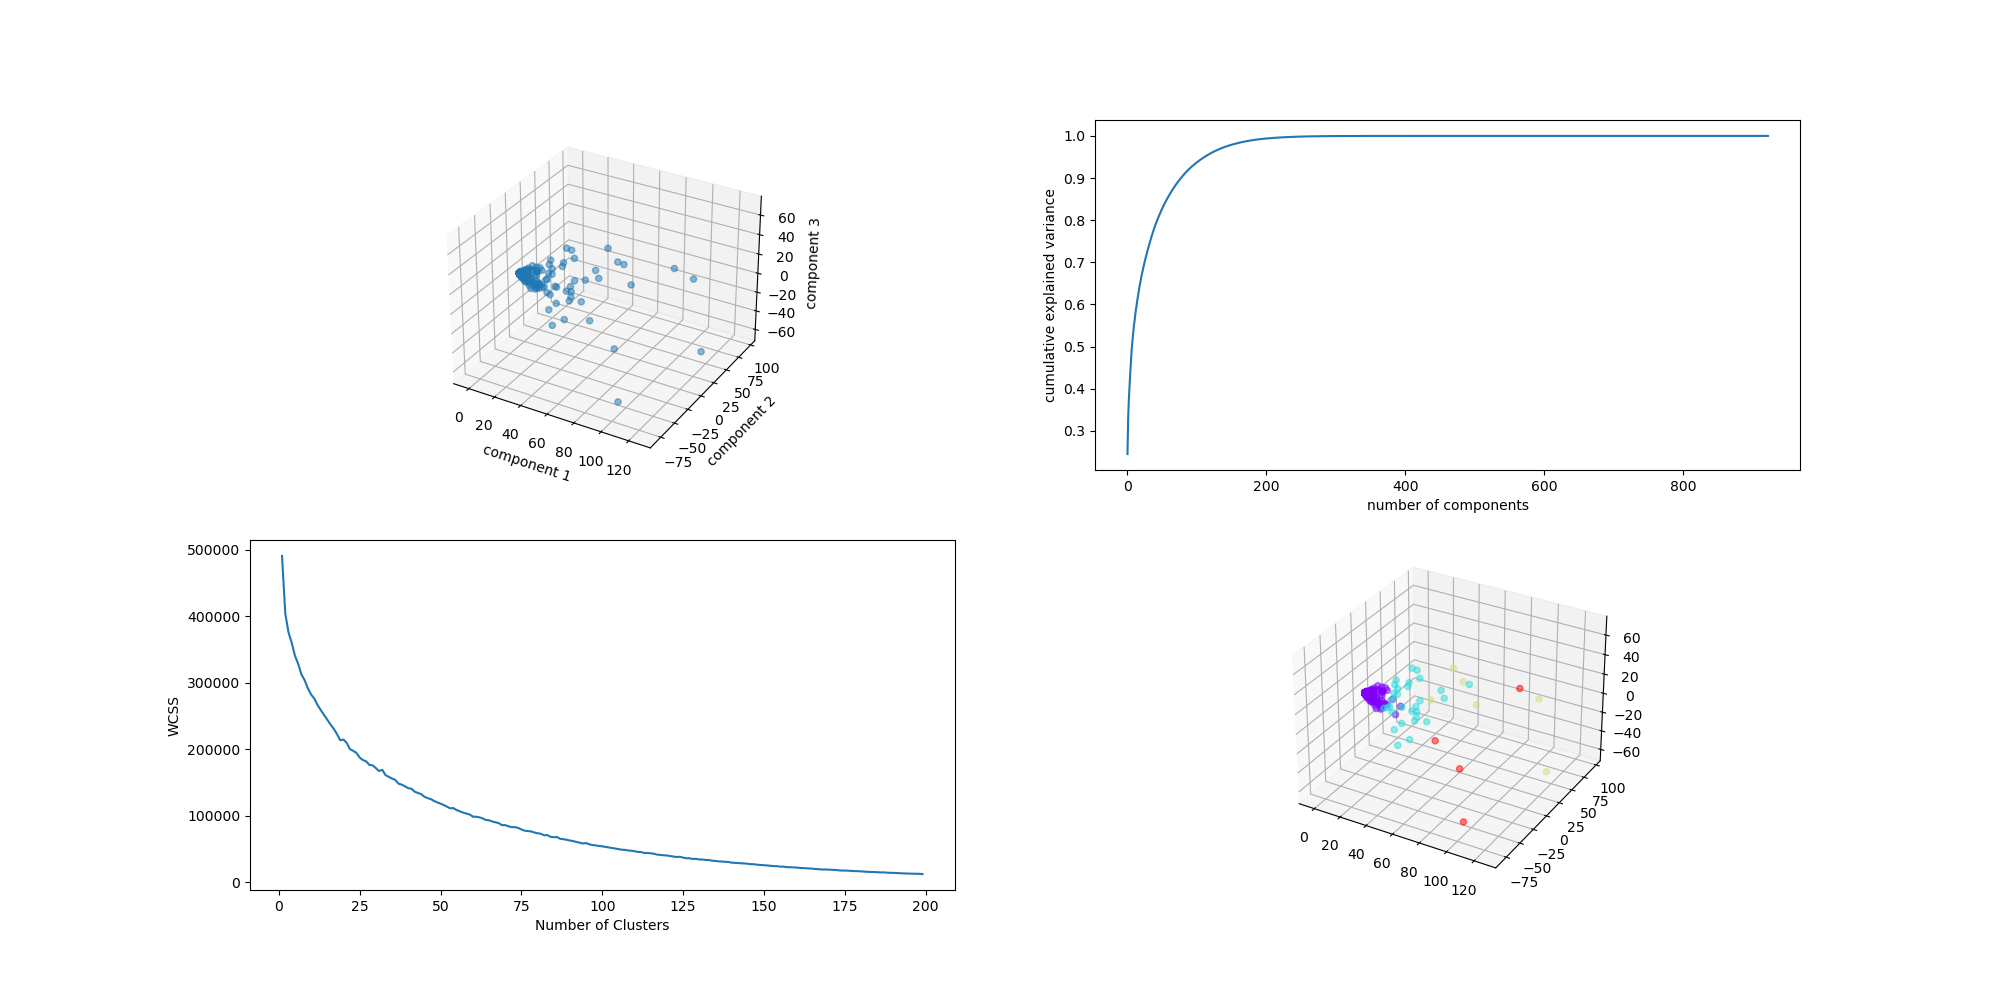

In [28]:
# PCA on malts
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
#import pandas as pd

with Session(engine) as session:
  # Gather up all our malts/grains
  malts_db = session.scalars(select(Grain)).all()
  malt_names = [malt.name for malt in malts_db]

  malt_props = ["srm", "c/f diff", "moisture", "protein", "dp", "yield"]
  malt_arr   = [[malt.colour_srm, malt.coarse_fine_diff, malt.moisture, malt.protein, malt.diastatic_power, malt.dbfg, *style_counts(malt.id)] for malt in malts_db]
  #malt_props = ["srm", "dp", "yield"]
  #malt_arr   = [[malt.colour_srm, malt.diastatic_power, malt.dbfg] for malt in malts_db]
  malt_A = np.array(malt_arr)
  #print(pd.DataFrame(malt_A, columns=malt_props)) # Show the table of malts

  scaler = StandardScaler()
  scaler.fit_transform(malt_A)

  #print(scaler.mean_)
  #print(np.sqrt(scaler.var_))
  #print(scaler.transform(malt_A))
  malt_A_n = scaler.transform(malt_A)
  malt_pca = PCA(n_components=3)
  malt_pcs = malt_pca.fit_transform(malt_A_n)
  print(malt_pcs.shape)
  #print(malt_pca.explained_variance_)
  #print(pd.DataFrame(data=malt_pcs, columns=["PC1", "PC2"]))

  fig = plt.figure(figsize=(20,10))
  ax = fig.add_subplot(2,2,1,projection='3d')
  ax.scatter(malt_pcs[:,0], malt_pcs[:,1], malt_pcs[:,2], alpha=0.5)
  ax.set_xlabel("component 1")
  ax.set_ylabel("component 2")
  ax.set_zlabel("component 3")
  
  
  pca = PCA().fit(malt_A_n)
  ax2 = fig.add_subplot(2,2,2)
  ax2.plot(np.cumsum(pca.explained_variance_ratio_))
  ax2.set_xlabel('number of components')
  ax2.set_ylabel('cumulative explained variance');
  


  wcss = [] # Within-Cluster-Sum-of-Squares
  for i in range(1,20):
    kmeans = KMeans(i)
    kmeans.fit(malt_A_n)
    wcss.append(kmeans.inertia_)
  ax3 = fig.add_subplot(2,2,3)
  ax3.plot(range(1,20), wcss)
  ax3.set_xlabel("Number of Clusters")
  ax3.set_ylabel("WCSS")


  #malt_pca2 = PCA(n_components=2)
  #malt_pcs = malt_pca2.fit_transform(malt_A_n)
  kmeans = KMeans(n_clusters=4, init='k-means++')
  clusters = kmeans.fit_predict(malt_pcs)
  ax4 = fig.add_subplot(2,2,4,projection='3d')
  ax4.scatter(malt_pcs[:,0], malt_pcs[:,1], malt_pcs[:,2], alpha=0.5, c=clusters, cmap='rainbow')
  

  plt.show()
  # It looks like it takes 200 principal components to represent malts... malts should probably have an embed space of 200



In [ ]:
# Inputs:

# Malt bill (16 slots):
# - % of each malt in the bill [float: [0,1]]
# - type [Categorical: 732 classes] TODO: Clean this up into a smaller space (there are a lot of repeats across suppliers), Embed to a smaller dimension (NOTE: 200 dimensions accomodates all variance based on PCA and k-means analysis)

# Hops (32 slots):
# - stage [('aroma',), ('boil',), ('dry hop',), ('first wort',), ('mash',)] [Categorical: 5 classes] - One-hot encoded
# - quantity - either in IBUs (for aroma, boil, first wort) or g/L (for mash, dry hop) [normalized float]
# - time - in minutes [normalized float?]
# - type [Categorical: 272 classes] TODO: Clean this up into a smaller space if possible, embed to a smaller dimension

# Adjuncts (8 slots):
# - stage [('boil',), ('bottling',), ('mash',), ('primary',), ('secondary',)] [Categorical: 5 classes] - One-hot encoded
# - quantity (in kgs or mls) [normalized float]

# Misc ... we're going to need to clean this up to remove unnessary items like finings etc.

# Mash Stages (6 slots):

# Fermentation Stages (2 slots):
# - time (in days) [normalized float]
# - temperature (in C) [normalized float]
